In [1]:
import essentia.standard
import os
import torch
import argparse
import numpy as np
import matplotlib.pyplot as plt

from data import get_dataset
from model import load_model
from utils import post_config_hook

/home/jspijkervet/.local/lib/python3.6/site-packages/librosa/util/decorators.py:9: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import of 'jit' requested from: 'numba.decorators', please update to use 'numba.core.decorators' or pin to Numba version 0.48.0. This alias will not be present in Numba version 0.50.0.
  from numba.decorators import jit as optional_jit


In [2]:
from utils import load_context_config
args = argparse.Namespace()

args.model_path = "./logs/audio/magnatagatune/clmr/1"
args.epoch_num = 1490
args.logistic_epochs = 0
args.mlp = 0
args = load_context_config(args)
args.reload = True

In [3]:
args.lin_eval = False  # first, pre-train, after that, lin. evaluation
args.n_gpu = torch.cuda.device_count()
args.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
args.at_least_one_pos = False
args.global_step = 0
args.current_epoch = 0


In [4]:
(train_loader, train_dataset, test_loader, test_dataset) = get_dataset(args)

### Pre-training, using whole dataset ###
Removed duplicates from: 18706 to: 3923
Num segments: 3923
Num tracks: 3923
[Train dataset (concat_12000)]: Loaded mean/std: -1.10129195e-05, 0.14225121
### Pre-training, using whole dataset ###
Removed duplicates from: 5329 to: 1129
Num segments: 1129
Num tracks: 1129
[Test dataset (concat_12000)]: Loaded mean/std: -1.10129195e-05, 0.14225121


In [6]:
model, optimizer, scheduler = load_model(
    args, reload_model=args.reload, name=args.model_name
)

model = model.eval() # set in evaluation mode (dropout, bn, etc.)
# print(model)

### SampleCNN12000 ###
### RELOADING CLMR MODEL FROM CHECKPOINT 1490 ###
### Using Adam optimizer ###
### RELOADING CLMR OPTIMIZER FROM CHECKPOINT 1490 ###


In [7]:
def tensor_to_audio_sig(tensor):
    return tensor[0].permute(1,0).squeeze(1).cpu().numpy() # swap channel / samples

## Random input

In [8]:
## placeholder for the input images (None,59049,1)
input_audio = np.random.uniform(-1, 1, (1, 1, args.audio_length))
input_audio = torch.from_numpy(input_audio).float().to(args.device)

(-1555.15, 32658.15, -1.099968323111534, 1.099998304247856)

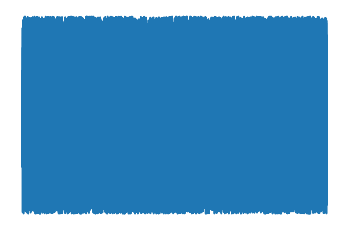

In [9]:
x = tensor_to_audio_sig(input_audio)
plt.clf()
plt.plot(x)
plt.axis('off')

In [10]:
from scipy import signal

def plot_spectogram(x):
    f, t, Sxx = signal.spectrogram(x, args.sample_rate)
    plt.pcolormesh(t, f, Sxx)
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [sec]')
    plt.show()


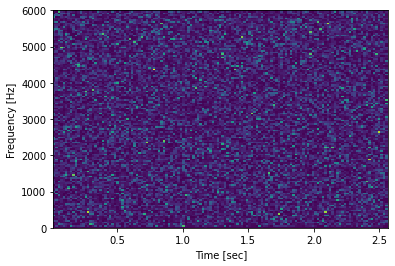

In [11]:
plot_spectogram(x)

In [12]:
## adjust model to first 7 layers
import torch.nn as nn

filter_model = nn.Sequential(*list(model.encoder.children())[:6])
filter_model = filter_model.eval()
filter_model

Sequential(
  (0): Sequential(
    (0): Conv1d(1, 128, kernel_size=(3,), stride=(3,))
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (1): Sequential(
    (0): Conv1d(128, 128, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool1d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  )
  (2): Sequential(
    (0): Conv1d(128, 128, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool1d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  )
  (3): Sequential(
    (0): Conv1d(128, 256, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool1d(kernel_size=3, stride

In [13]:
class SaveFeatures():
    def __init__(self, args, module):
        self.args = args
        self.hook = module.register_forward_hook(self.hook_fn)
    def hook_fn(self, module, input, output):
        self.features = output.detach().clone().requires_grad_(True).to(self.args.device)
    def close(self):
        self.hook.remove()


class FilterVisualizer():
    def __init__(self, args, model):
        self.args = args
        self.model = model.cuda().eval()

    def visualize(self, x, layer, filter_idx, lr=0.1, opt_steps=20):
        activations = SaveFeatures(self.args, self.model._modules.get(layer)[2])  # register hook
        optimizer = torch.optim.Adam([x], lr=lr)
        for n in range(opt_steps):
            optimizer.zero_grad() # Reset the gradients
            self.model(x)
            loss = -activations.features[0, filter_idx].mean()
            loss.backward() # calculate the gradients of the pixel values with loss.backward()
            optimizer.step() # change the pixel values with optimizer.step().
        
        activations.close()
        return x

In [14]:
import librosa
import librosa.display
import os

if not os.path.exists("media/filters_waveform"):
    os.makedirs("media/filters_waveform")
    
if not os.path.exists("media/filters_spectrum"):
    os.makedirs("media/filters_spectrum")

In [15]:
from scipy.signal import butter, lfilter, freqz

def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y

In [16]:
## placeholder for the audio  (1, audio_len, 1)
sample_length = 729
fftsize = 729

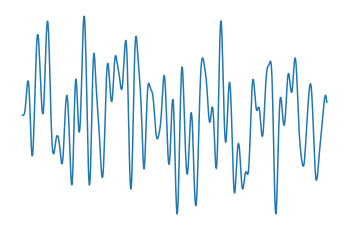

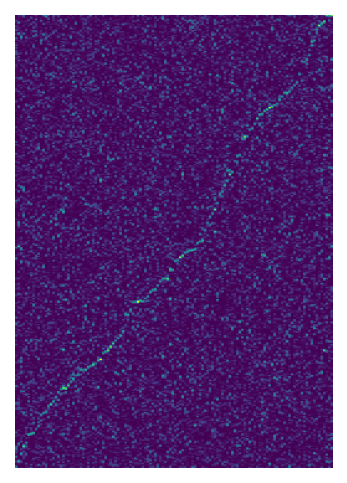

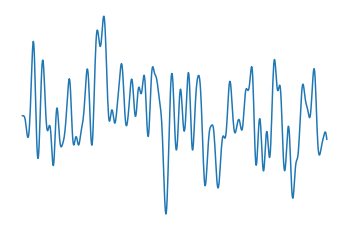

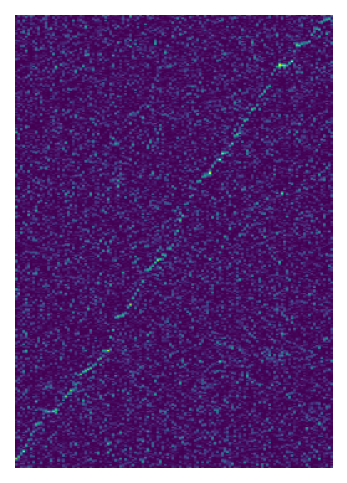

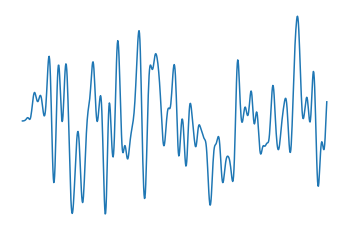

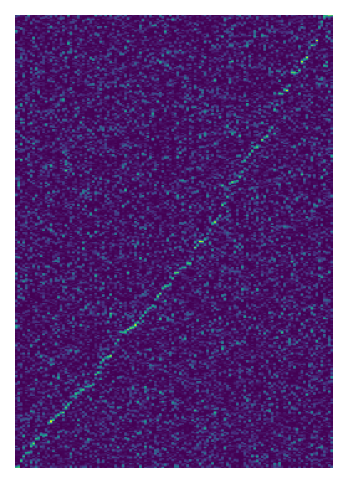

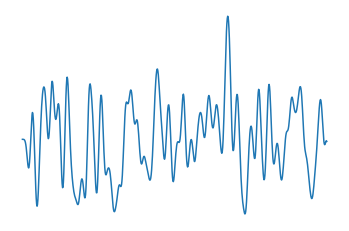

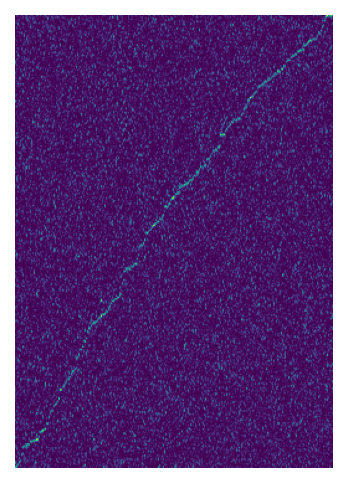

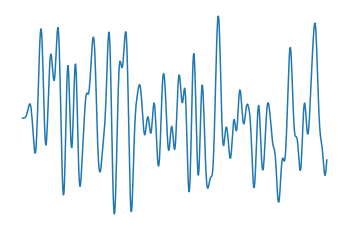

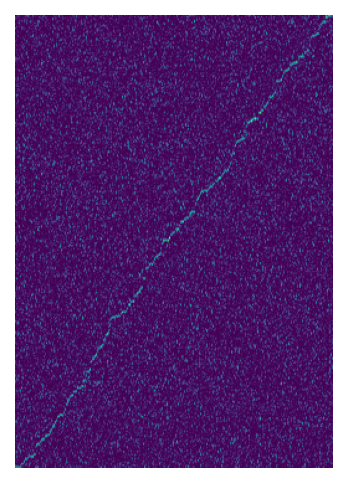

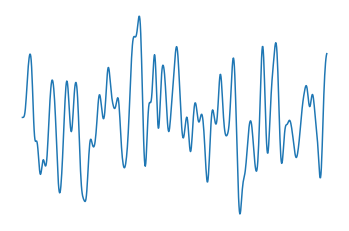

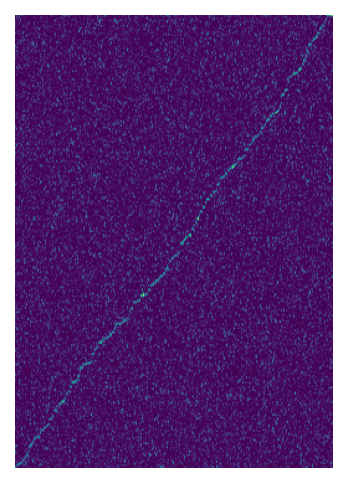

In [20]:
filters = [128, 128, 128, 256, 256, 256]
num_layers = len(filter_model)

vs = FilterVisualizer(args, filter_model)
for idx, layer in enumerate(range(num_layers)):
    
    num_filters = filters[idx]
    repetition = int((fftsize/2+1)/num_filters)

    fftzed = np.zeros((num_filters, int(fftsize/2+1)))
    for filter_idx in range(0, num_filters):

#         input_audio = np.random.random((1, 1, sample_length))
#         input_audio = (input_audio - 0.5) * 0.03 #1.8
        input_audio = np.random.uniform(-0.005, 0.005, (1, 1, sample_length))
        input_audio = torch.from_numpy(input_audio).float().to(args.device)
        
#         input_audio = train_loader.dataset.normalise_audio(input_audio)
        input_audio.requires_grad = True

        
        output = vs.visualize(input_audio, str(layer), filter_idx-1, opt_steps=18)
        sample = tensor_to_audio_sig(output.detach())
        sample = sample - np.mean(sample) # remove dc
        
        # only save the last one to save space
        if filter_idx == num_filters-1:
            plt.clf()
            # low-pass sample to get dominant frequencies
            lowpass_sample = butter_lowpass_filter(sample, 600, args.sample_rate, order=6)
            plt.plot(lowpass_sample)
            plt.axis('off')
            plt.savefig(f"media/filters_waveform/{layer}_{filter_idx}.png")
        
        S = librosa.core.stft(sample,n_fft=fftsize,hop_length=fftsize,win_length=fftsize)
        X = np.square(np.absolute(S))
        log_S = np.log10(1+10*X)
#         print(log_S.shape)
        log_S = np.squeeze(log_S.astype(np.float32))
        fftzed[filter_idx] = log_S
           
    
    argmaxed = np.argmax(fftzed, axis=1)
    sort_idx = np.argsort(argmaxed)
    sorted_fft = fftzed[sort_idx,:]
    sorted_fft = np.repeat(sorted_fft, repetition, axis=0)
#     sorted_fft = np.flip(sorted_fft)
    
    plt.figure(dpi=150)
    plt.clf()
    plt.imshow(sorted_fft.T, cmap=plt.get_cmap("viridis"))
    plt.gca().invert_yaxis()
    plt.axis("off")
    plt.savefig(f"media/filters_spectrum/{layer}.png")
    plt.show()
